# Post Data Analysis

In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
import math

plt.rcParams["figure.figsize"] = (20, 10)


## Load Data
### Set start and end points
By examine output data

In [4]:
# set results path
results_file = "data_out_simple_nozzle_run_without_firing.csv"

startPoint = 37000 # ms
endPoint = 58000# ms

data = pd.read_csv(results_file)
duration = data["timestamp"].isin(range(startPoint, endPoint))
data = data[duration]

data_np = data.to_numpy()


### A quick overview of the raw data, check if any sensors are installed in the wrong orientation


check correlation matrix


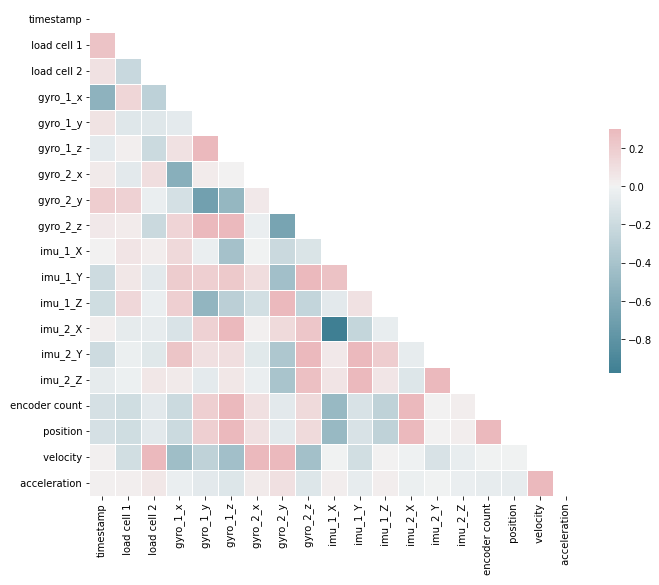

In [5]:
corr_mat = data.corr()
mask = np.zeros_like(corr_mat, dtype=bool) 
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Actual pairwise chart. Takes a long time to render, uncomment and run if want to.

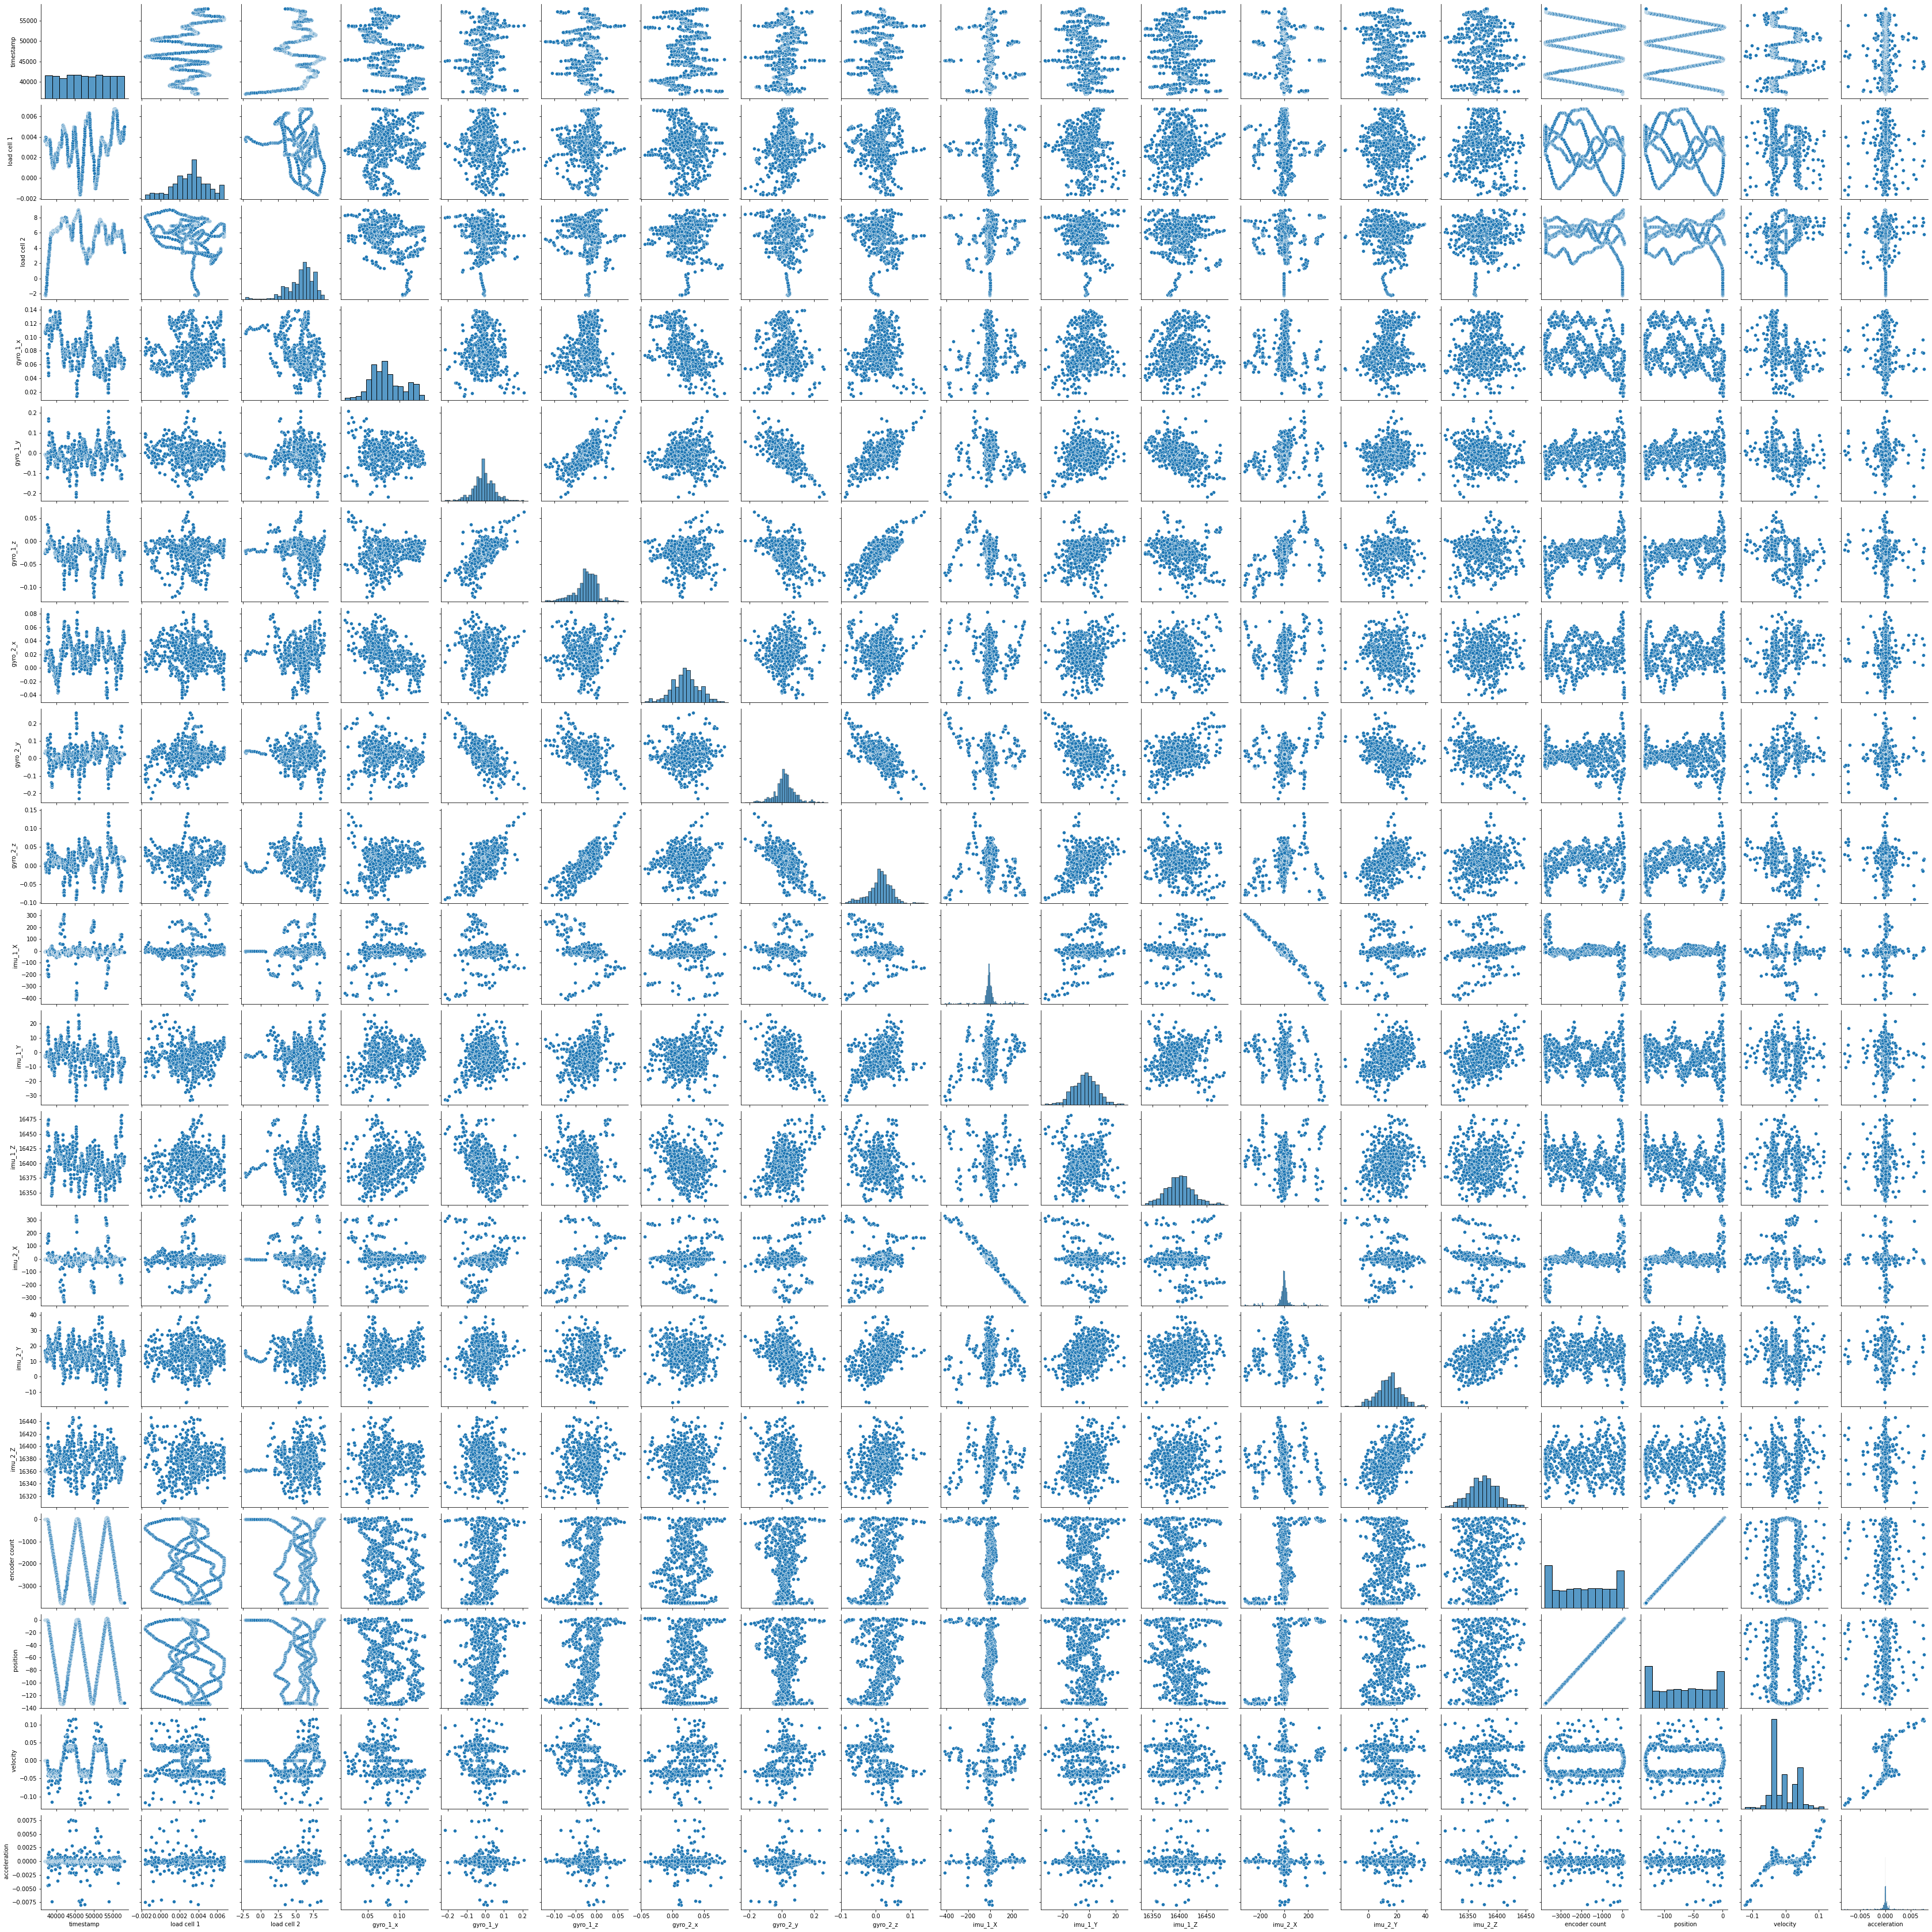

In [6]:
sns.pairplot(data)
plt.show()


## Analise Linear Encoder Results

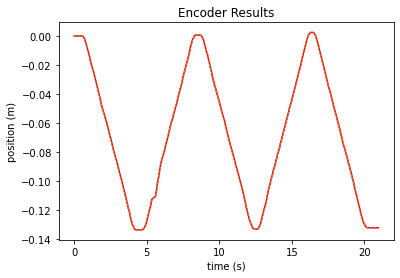

In [7]:
# set specs of encoder
resolution = 35.27777778 / 1000000 # in m
uncertainty = 93.4498 / 1000000 # in m

time = data_np[:, 0]
time = time - time[0] # in ms
time = time / 1000 # in s

position = data_np[:, 15]
position = position - position[0] # zero the measurement
# assument starting position as at 0 micron, encoder resolution is 35.27777778 microns and uncertainty (including initial position within one resolution) is +- 93.4498 microns

position = position * resolution
position_lower_bound = position - uncertainty
position_upper_bound = position + uncertainty


# plot position
plt.plot(time, position, 'r')
plt.plot(time, position_lower_bound, ':')
plt.plot(time, position_upper_bound, ':')
plt.title("Encoder Results")
plt.xlabel("time (s)")
plt.ylabel("position (m)")
plt.show()


### Velocity estimation from encoder data


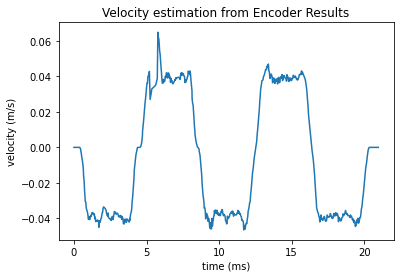

In [27]:
velocity = np.array([float(0)] * time.size)
smooth_factor = 5
for i in range(smooth_factor):
    for j in [1+i, -2-i]:
        velocity[j] = (position[j+1+i] - position[j-1-i])/(time[j+1+i] - time[j-1-i])

for i in range(smooth_factor, time.size-1-smooth_factor):
    velocity[i] = (position[i+smooth_factor] - position[i-smooth_factor])/(time[i+smooth_factor] - time[i-smooth_factor])
plt.plot(time, velocity)
plt.title("Velocity estimation from Encoder Results")
plt.xlabel("time (ms)")
plt.ylabel("velocity (m/s)")
plt.show()

### Acceleration estimation from encoder velocity estimation


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


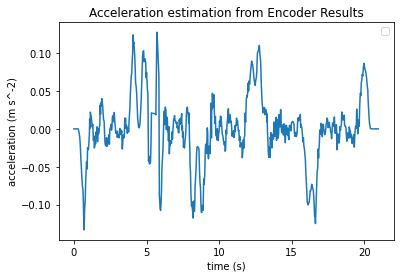

In [110]:
acceleration = np.array([float(0)] * time.size)
smooth_factor = 3
for i in range(smooth_factor):
    for j in [1+i, -2-i]:
        acceleration[j] = (velocity[j+1+i] - velocity[j-1-i])/(time[j+1+i] - time[j-1-i])

for i in range(smooth_factor, time.size-1-smooth_factor):
    acceleration[i] = (velocity[i+smooth_factor] - velocity[i-smooth_factor])/(time[i+smooth_factor] - time[i-smooth_factor])
plt.plot(time, acceleration)
plt.title("Acceleration estimation from Encoder Results")
plt.xlabel("time (s)")
plt.ylabel("acceleration (m s^-2)")
# plt.ylim((-0.1, 0.1))
plt.legend(loc="upper right")
plt.show()

## IMU Results

### Acceleration on x direction


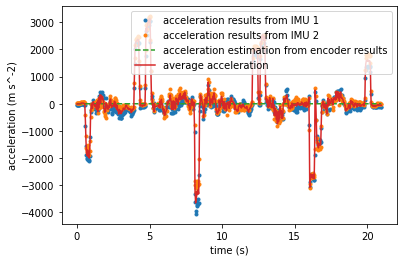

In [111]:
g = 9.8

acc1 = data_np[:, 9] * g
acc2 = data_np[:, 12] * (-1) * g
x_acc = (acc1 + acc2)/2


plt.plot(time, acc1, '.', label="acceleration results from IMU 1")
plt.plot(time, acc2, '.', label="acceleration results from IMU 2")
plt.plot(time, acceleration, "--", label="acceleration estimation from encoder results")
plt.plot(time, x_acc, label="average acceleration")
plt.xlabel("time (s)")
plt.ylabel("acceleration (m s^-2)")
# plt.ylim((-1, 1))
plt.legend(loc="upper right")
plt.show()

/home/yubai/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[13.90258753 14.74005169  0.1       ]


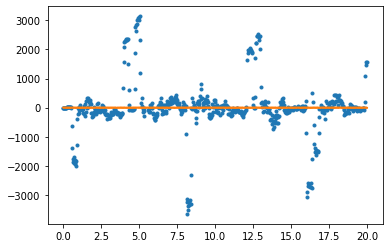

In [112]:
# fit sine curve
start = 0 # s
end = 20
# estimation from graph
A = 0.15
f = 15


# bounds = ((A[0],f[0], 0.01), (A[1],f[1], 2*math.pi))

t = time[(start <= time) & (time <= end)]
y = x_acc[(start <= time) & (time <= end)]


def sine_func(t, A, f, phi):
    return A*np.sin(2*math.pi*f*t)

# params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[sum(A)/2, sum(f)/2, 0.1], bounds=bounds)
params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[A, f, 0.1])

print(params)

A = params[0]
f = params[1]
phi = params[2]


plt.plot(t, y, '.')
t = np.linspace(start, end, num=int((start + end)/0.01), endpoint=True)
plt.plot(t, A*np.sin(2*math.pi*f*t + phi))
plt.show()



### accelerometer in y and z direction

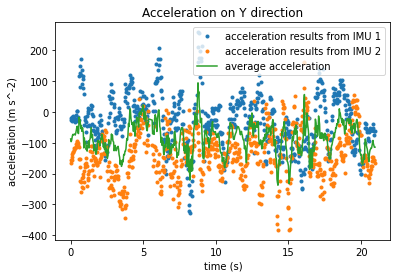

In [113]:
acc1 = data_np[:, 10] * g
acc2 = data_np[:, 13] * (-1) * g
y_acc = (acc1 + acc2)/2

plt.title("Acceleration on Y direction")
plt.plot(time, acc1, '.', label="acceleration results from IMU 1")
plt.plot(time, acc2, '.', label="acceleration results from IMU 2")
plt.plot(time, y_acc, label="average acceleration")
plt.xlabel("time (s)")
plt.ylabel("acceleration (m s^-2)")
# plt.ylim((-1, 1))
plt.legend(loc="upper right")
plt.show()

[-3.08707261  9.8780307   0.1       ]


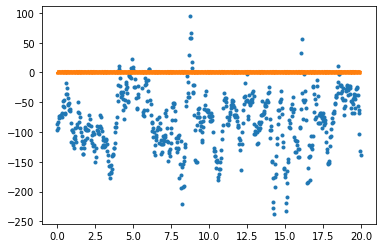

In [114]:
# fit sine curve
start = 0 # s
end = 20
# estimation from graph
A = 0.05
f = 10

# bounds = ((A[0],f[0], 0.01), (A[1],f[1], 2*math.pi))

t = time[(start <= time) & (time <= end)]
y = y_acc[(start <= time) & (time <= end)]


def sine_func(t, A, f, phi):
    return A*np.sin(2*math.pi*f*t)

# params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[sum(A)/2, sum(f)/2, 0.1], bounds=bounds)
params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[A, f, 0.1])

print(params)

A = params[0]
f = params[1]
phi = params[2]


plt.plot(t, y, '.')
t = np.linspace(start, end, num=int((start + end)/0.01), endpoint=True)
plt.plot(t, A*np.sin(2*math.pi*f*t + phi))
plt.show()

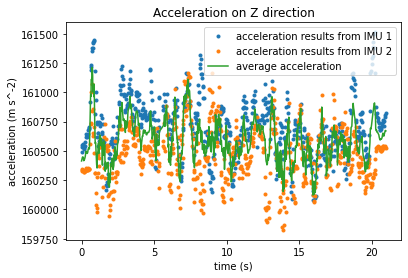

In [122]:
acc1 = data_np[:, 11] * g - g
acc2 = data_np[:, 14]  * g - g
z_acc = (acc1 + acc2)/2

plt.title("Acceleration on Z direction")
plt.plot(time, acc1, '.', label="acceleration results from IMU 1")
plt.plot(time, acc2, '.', label="acceleration results from IMU 2")
plt.plot(time, z_acc, label="average acceleration")
plt.xlabel("time (s)")
plt.ylabel("acceleration (m s^-2)")
# plt.ylim((-1, 1))
plt.legend(loc="upper right")
plt.show()

[ 0.07998716 19.98106161  0.1       ]


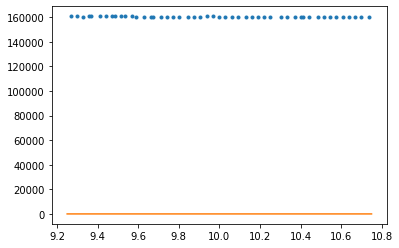

In [123]:
# fit sine curve
start = 9.25 # s
end = 10.75
# estimation from graph
A = 0.05
f = 10


# bounds = ((A[0],f[0], 0.01), (A[1],f[1], 2*math.pi))

t = time[(start <= time) & (time <= end)]
y = z_acc[(start <= time) & (time <= end)]


def sine_func(t, A, f, phi):
    return A*np.sin(2*math.pi*f*t)

# params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[sum(A)/2, sum(f)/2, 0.1], bounds=bounds)
params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[A, f, 0.1])

print(params)

A = params[0]
f = params[1]
phi = params[2]


plt.plot(t, y, '.')
t = np.linspace(start, end, num=int((start + end)/0.01), endpoint=True)
plt.plot(t, A*np.sin(2*math.pi*f*t + phi))
plt.show()

## Rotational Results

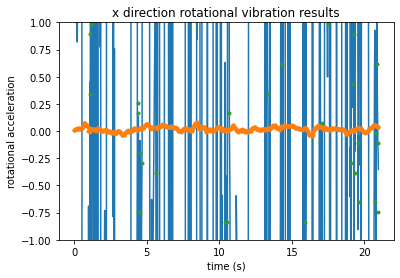

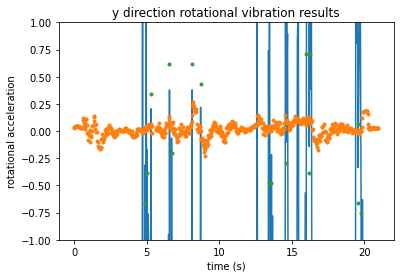

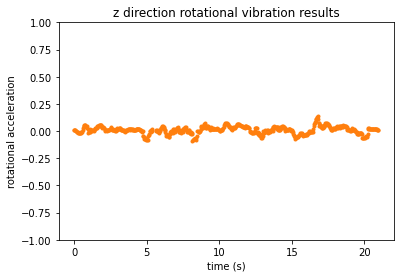

In [124]:
# rotation on x direction
rot1 = data_np[:, 6]
rot2 = data_np[:, 12] * (-1)
x_rot = (rot1 + rot2)/2

plt.plot(time, x_rot, label="average")
plt.plot(time, rot1, '.', label="IMU 1")
plt.plot(time, rot2, '.', label="IMU 2")
plt.ylim((-1, 1))
plt.xlabel("time (s)")
plt.ylabel("rotational acceleration")
plt.title("x direction rotational vibration results")
plt.show()

# rotation on y direction
rot1 = data_np[:, 7]
rot2 = data_np[:, 13] * (-1)
y_rot = (rot1 + rot2)/2

plt.plot(time, y_rot, label="average")
plt.plot(time, rot1, '.', label="IMU 1")
plt.plot(time, rot2, '.', label="IMU 2")
plt.ylim((-1, 1))
plt.xlabel("time (s)")
plt.ylabel("rotational acceleration")
plt.title("y direction rotational vibration results")
plt.show()

# rotation on z direction
rot1 = data_np[:, 8]
rot2 = data_np[:, 14]
z_rot = (rot1 + rot2)/2

plt.plot(time, z_rot, label="average")
plt.plot(time, rot1, '.', label="IMU 1")
plt.plot(time, rot2, '.', label="IMU 2")
plt.ylim((-1, 1))
plt.xlabel("time (s)")
plt.ylabel("rotational acceleration")
plt.title("z direction rotational vibration results")
plt.show()


[11.14548643  1.52139662  0.1       ]


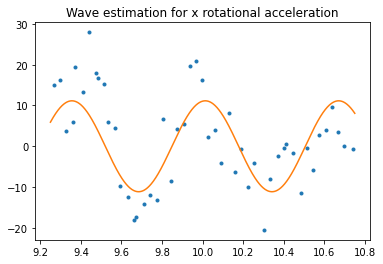

In [125]:
# fit sine curve
start = 9.25 # s
end = 10.75
# estimation from graph
A = [0.05, 0.10]
f = [1, 2]


t = time[(start <= time) & (time <= end)]
y = x_rot[(start <= time) & (time <= end)]


def sine_func(t, A, f, phi):
    return A*np.sin(2*math.pi*f*t)

params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[sum(A)/2, sum(f)/2, 0.1])

print(params)

A = params[0]
f = params[1]
phi = params[2]


plt.plot(t, y, '.')
t = np.linspace(start, end, num=int((start + end)/0.01), endpoint=True)
plt.plot(t, A*np.sin(2*math.pi*f*t + phi))
plt.title("Wave estimation for x rotational acceleration")
plt.show()

[-0.85504369  1.38610309  0.1       ]


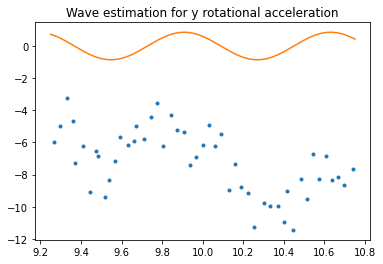

In [126]:
# fit sine curve
start = 9.25 # s
end = 10.75
# estimation from graph
A = [0.05, 0.10]
f = [1, 2]


t = time[(start <= time) & (time <= end)]
y = y_rot[(start <= time) & (time <= end)]


def sine_func(t, A, f, phi):
    return A*np.sin(2*math.pi*f*t)

params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[sum(A)/2, sum(f)/2, 0.1])

print(params)

A = params[0]
f = params[1]
phi = params[2]


plt.plot(t, y, '.')
t = np.linspace(start, end, num=int((start + end)/0.01), endpoint=True)
plt.plot(t, A*np.sin(2*math.pi*f*t + phi))
plt.title("Wave estimation for y rotational acceleration")
plt.show()

[5.86349652e+02 1.62940247e+01 1.00000000e-01]


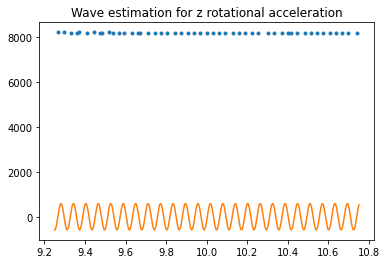

In [127]:
# fit sine curve
start = 9.25 # s
end = 10.75
# estimation from graph
A = [0.05, 0.10]
f = [1, 2]


t = time[(start <= time) & (time <= end)]
y = z_rot[(start <= time) & (time <= end)]


def sine_func(t, A, f, phi):
    return A*np.sin(2*math.pi*f*t)

params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[sum(A)/2, sum(f)/2, 0.1])

print(params)

A = params[0]
f = params[1]
phi = params[2]


plt.plot(t, y, '.')
t = np.linspace(start, end, num=int((start + end)/0.01), endpoint=True)
plt.plot(t, A*np.sin(2*math.pi*f*t + phi))
plt.title("Wave estimation for z rotational acceleration")
plt.show()

## Tension Results

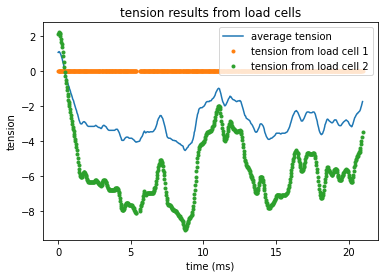

In [128]:
load1 = data_np[:, 1]
load2 = data_np[:, 2] * (-1)
tension = (load1 + load2) / 2
plt.plot(time, tension, label="average tension")
plt.plot(time, load1, '.', label="tension from load cell 1")
plt.plot(time, load2, '.', label="tension from load cell 2")
plt.xlabel("time (ms)")
plt.ylabel("tension")
plt.title("tension results from load cells")
plt.legend(loc="upper right")
plt.show()


## pairwise chart for everything

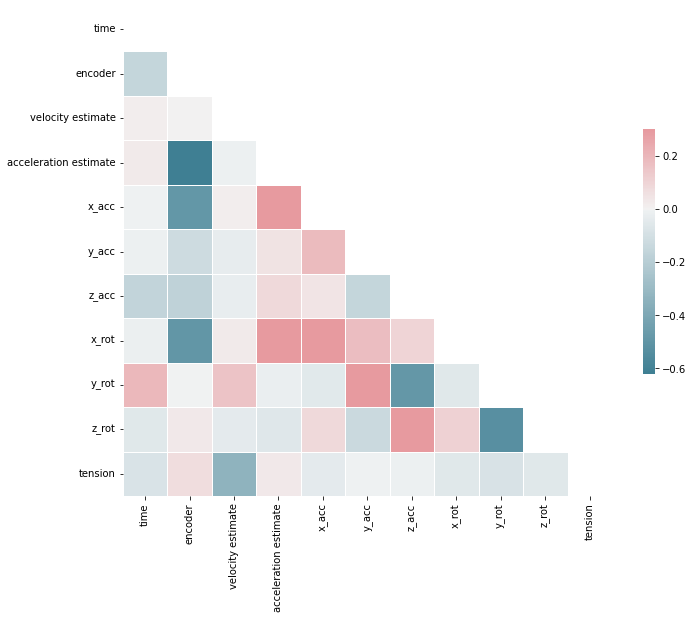

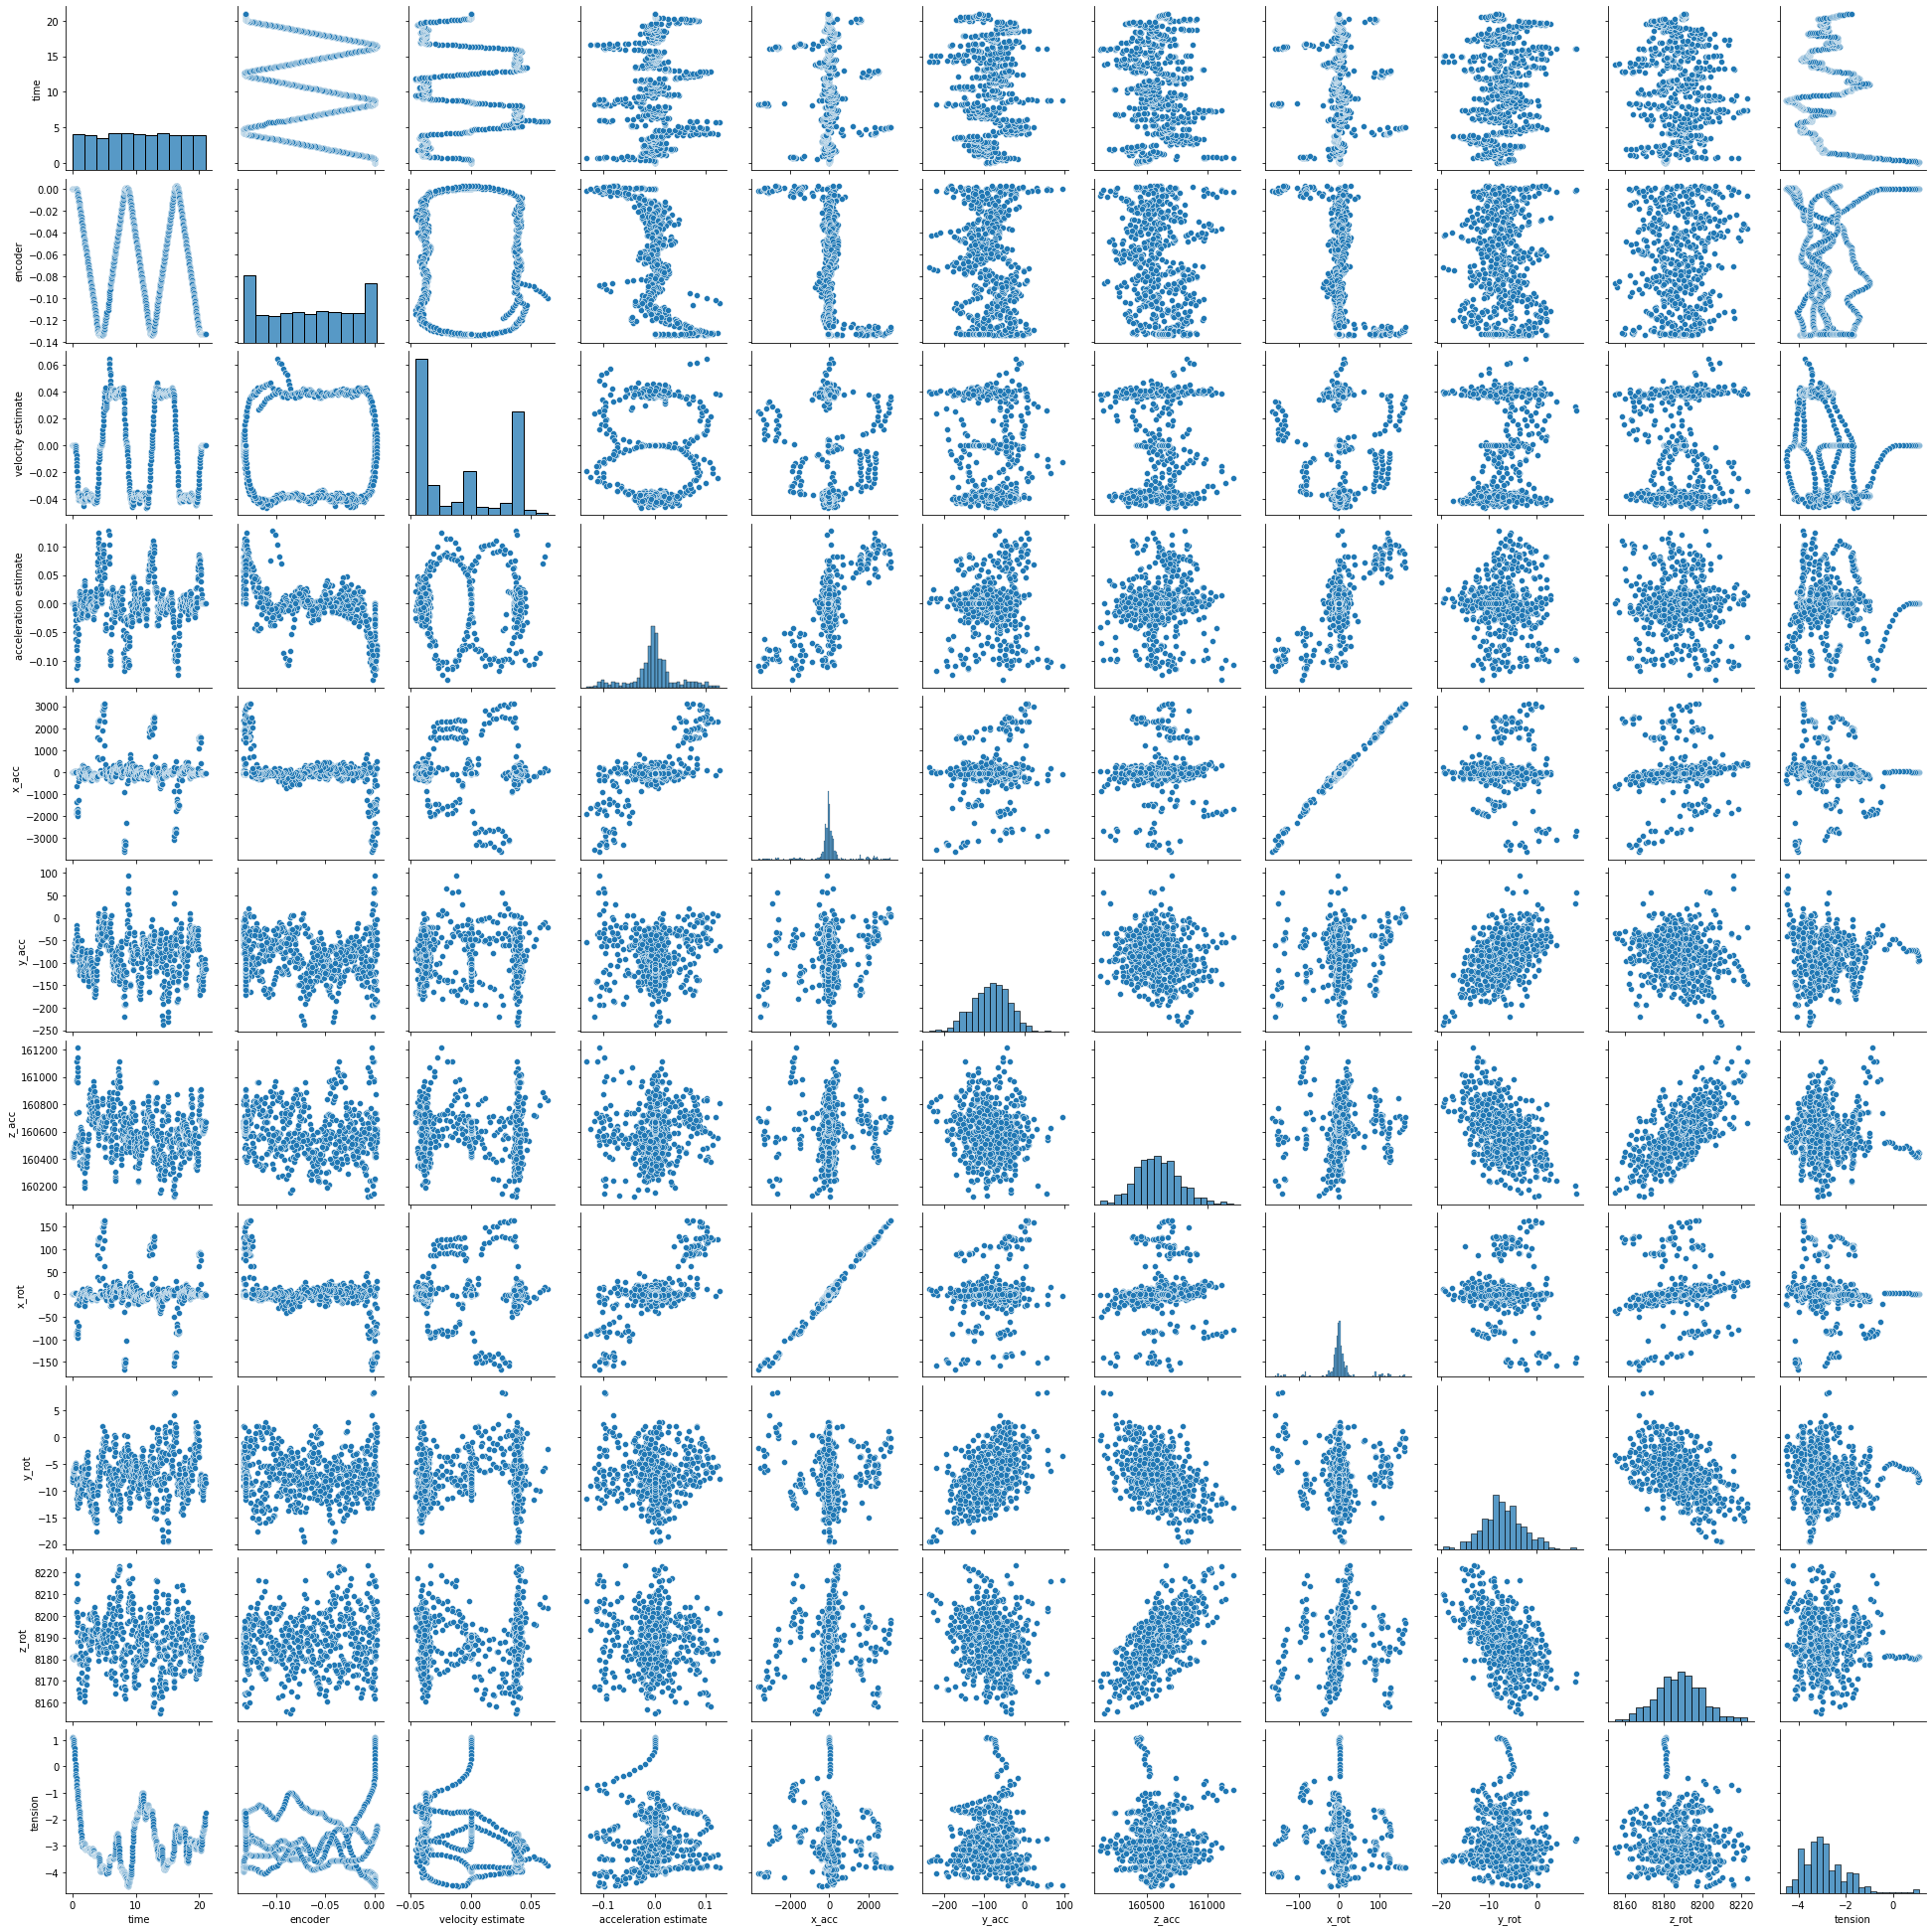

In [129]:
# final data

final_data = pd.DataFrame({"time": time, "encoder": position, "velocity estimate": velocity, "acceleration estimate": acceleration, "x_acc": x_acc, "y_acc": y_acc, "z_acc": z_acc, "x_rot": x_rot, "y_rot": y_rot, "z_rot": z_rot, "tension": tension},columns=["time", "encoder", "velocity estimate", "acceleration estimate", "x_acc", "y_acc", "z_acc", "x_rot", "y_rot", "z_rot", "tension"])

corr_mat = final_data.corr()
mask = np.zeros_like(corr_mat, dtype=bool) 
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

sns.pairplot(final_data)
plt.show()